In [2]:
import os
import torch
import pandas as pd
from polymerlearn.utils import get_Tg_add, GraphDataset

# Load data from local path:
data = pd.read_csv(os.path.join('/Users/owenqueen/Desktop/eastman_project-confidential/Eastman_Project/PolymerGNN/dataset', 
            'pub_data.csv'))

In [3]:
add = get_Tg_add(data)

dataset = GraphDataset(
    data = data,
    structure_dir = '../Structures/AG/xyz',
    Y_target=['Tg'],
    test_size = 0.2,
    add_features=add
)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
from polymerlearn.models.gnn import PolymerGNN_IV
from polymerlearn.utils import CV_eval

model_kwargs = {
    'input_feat': 6,         # How many input features on each node; don't change this
    'hidden_channels': 32,   # How many intermediate dimensions to use in model
                            # Can change this ^^
    'num_additional': 4      # How many additional resin properties to include in the prediction
                            # Corresponds to the number in get_IV_add
}
model = PolymerGNN_IV(**model_kwargs)

optimizer_gen = torch.optim.AdamW
criterion = torch.nn.MSELoss()

all_predictions, all_y, all_inds, state_dicts = CV_eval(
    dataset = dataset,
    model_generator = PolymerGNN_IV,
    optimizer_generator = optimizer_gen,
    criterion = criterion,
    model_generator_kwargs = model_kwargs,
    optimizer_kwargs = {'lr': 0.0001, 'weight_decay':0.01},
    epochs = 800,
    batch_size = 64,
    verbose = 1,
    save_state_dicts=True
)

Fold: 1 	 Epoch: 0,                     	 Train r2: -1.5719 	 Train Loss: 5.6361


In [2]:
# torch.save((all_predictions, all_y, all_inds, state_dicts), open('CV_tup.pt', 'wb')) # Save state dicts to load later
# torch.save(dataset, 'dataset.pt')

all_predictions, all_y, all_inds, state_dicts = torch.load('CV_tup.pt')
dataset = torch.load('dataset.pt')

In [3]:
from polymerlearn.explain import PolymerGNN_IV_EXPLAIN, PolymerGNNExplainer

model_kwargs = {
    'input_feat': 6,         # How many input features on each node; don't change this
    'hidden_channels': 32,   # How many intermediate dimensions to use in model
                            # Can change this ^^
    'num_additional': 4      # How many additional resin properties to include in the prediction
                            # Corresponds to the number in get_IV_add
}

exps = []

for sd in state_dicts:

    mexplain = PolymerGNN_IV_EXPLAIN(**model_kwargs)
    mexplain.load_state_dict(sd) # Load weights from trained model over to explaining one

    explainer = PolymerGNNExplainer(mexplain)

    exp_out = explainer.get_testing_explanation(dataset)

    exps.append(exp_out)

/Users/owenqueen/Desktop/Eastman_project-Confidential/Eastman_Project/PolymerGNN/polymerlearn/utils/graph_prep.py:430: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640811925055/work/torch/csrc/utils/tensor_new.cpp:201.)
  return self.test_data, torch.tensor(self.Ytest).float(), torch.tensor(self.add_test).float()
/Users/owenqueen/Desktop/Eastman_project-Confidential/Eastman_Project/PolymerGNN/polymerlearn/explain/explain_gnn.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(add_test).float())


{'A': tensor([0.1597, 0.4210, 0.0000]), 'G': tensor([0.3037, 0.7066, 0.1263]), 'add': tensor([ 1.2291,  0.0088, -0.3796,  0.0199]), 'table_ind': 1}
['1,4-CHDA', 'IPA', 'TPA']
['1,4-CHDM', 'TMCD', 'TMP']
{'A': tensor([9.0485e-02, 5.1376e-01, 3.4706e-04]), 'G': tensor([0.5817, 0.1007, 0.2550]), 'add': tensor([ 1.0670, -0.0409, -0.3397,  0.0264]), 'table_ind': 3}
['SA', 'IPA', 'TPA']
['NPG', 'TMCD', 'TMP']
{'A': tensor([0.8820, 0.0134]), 'G': tensor([0.4839, 1.2696, 0.0132]), 'add': tensor([ 1.9859, -0.1172, -0.3213,  0.0000]), 'table_ind': 7}
['IPA', 'TPA']
['1,4-CHDM', 'TMCD', 'MPD']
{'A': tensor([0.7997, 0.0131]), 'G': tensor([0.4194, 0.0000, 0.9554, 0.2315]), 'add': tensor([ 1.7211, -0.1109, -0.3977,  0.0458]), 'table_ind': 8}
['IPA', 'TPA']
['HDO', '1,4-CHDM', 'TMCD', 'TMP']
{'A': tensor([1.0740, 0.0139]), 'G': tensor([0.5732, 1.3982, 0.2889, 0.0000]), 'add': tensor([ 2.4306, -0.1766, -0.3293,  0.0333]), 'table_ind': 13}
['IPA', 'TPA']
['1,4-CHDM', 'TMCD', 'TMP', 'MPD']
{'A': tensor(

In [4]:
def agg_exps(exp_list, add_data_keys = ['Mw', 'AN', 'OHN', '%TMP']):

    agg_addkeys = {a:[] for a in add_data_keys}
    acid_scores = []
    glycol_scores = []

    for i in range(len(exp_list)):
        for ad in add_data_keys:
            agg_addkeys[ad] += exp_list[i][3][ad]

        for j in range(len(exp_list[i][0])):
            acid_scores.append(torch.sum(exp_list[i][0][j]['A']).item())
            glycol_scores.append(torch.sum(exp_list[i][0][j]['G']).item())

    return acid_scores, glycol_scores, agg_addkeys


In [5]:
# Compute rankings:

acid_scores, glycol_scores, agg_addkeys = agg_exps(exps)

In [15]:
import numpy as np
for k, v in agg_addkeys.items():
    if k == '%TMP':
        v = np.abs(v)
        m = np.mean(v[v > 1e-9])
    else:
        m = np.mean(np.abs(v))
    print(f'{k} mean importance: {m}')

print('Acid embedding mean importance:', np.mean(acid_scores))
print('Glycol embedding mean importance', np.mean(glycol_scores))

Mw mean importance: 1.218886958807707
AN mean importance: 0.07777735689366333
OHN mean importance: 0.3234896620502695
%TMP mean importance: 0.03490294288203586
Acid embedding mean importance: 0.7388002542157968
Glycol embedding mean importance 0.7832086713363727


In [23]:
avg_scores = {
    'A':[],
    'G':[],
    'Mw':[],
    'AN':[],
    'OHN':[],
    '%TMP':[]
}

name_list = ['A', 'G', 'Mw', 'AN', 'OHN', '%TMP']

for i in range(len(acid_scores)):
    # Iterates over samples:
    l = [
        acid_scores[i],
        glycol_scores[i],
        agg_addkeys['Mw'][i],
        agg_addkeys['AN'][i],
        agg_addkeys['OHN'][i],
        agg_addkeys['%TMP'][i]
    ]

    sort_inds = list(np.argsort(np.abs(l)))
    sort_inds.reverse()

    for j, n in enumerate(name_list):
        avg_scores[n].append(sort_inds.index(j) + 1)

for k, v in avg_scores.items():
    print(f'{k} : {np.mean(v):.4f}')
    

A : 2.4875
G : 2.5083
Mw : 1.0083
AN : 5.0750
OHN : 3.9958
%TMP : 5.9250


Mw mean importance: 1.218886958807707
AN mean importance: -0.0755167142329204
OHN mean importance: -0.3234896620502695
%TMP mean importance: 0.02371821900305804
Acid embedding mean importance: 0.7388002542157968
Glycol embedding mean importance 0.7832086713363727


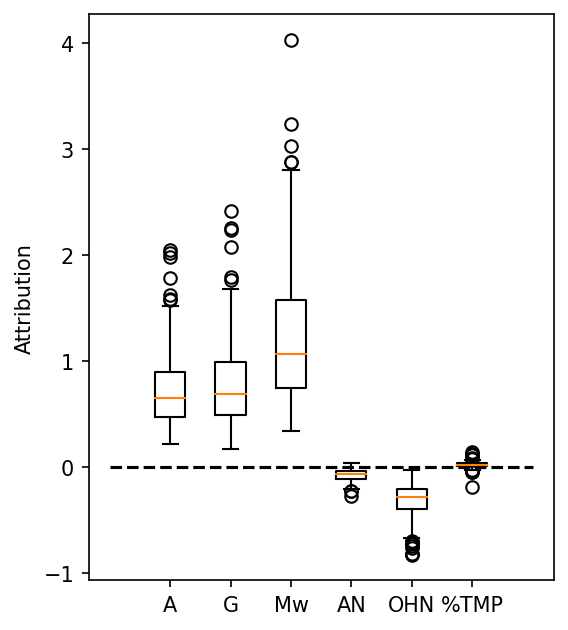

In [47]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(dpi=150, figsize=(4, 5))
all_data = []
all_data.append(acid_scores)
all_data.append(glycol_scores)

for k, v in agg_addkeys.items():
    if k == '%TMP':
        m = np.array(v)[np.abs(v) > 1e-9]
    else:
        m = v
    print(f'{k} mean importance: {np.mean(m)}')

    all_data.append(m)

print('Acid embedding mean importance:', np.mean(acid_scores))
print('Glycol embedding mean importance', np.mean(glycol_scores))



plt.hlines(0, xmin=0, xmax=len(name_list) + 1, colors = 'black', linestyles='dashed')
plt.boxplot(all_data)
plt.ylabel('Attribution')
plt.xticks(list(range(1, len(name_list) + 1)), name_list)

plt.show()

In [7]:
# Summarize importance scores:
from polymerlearn.utils.graph_prep import get_AG_info

# Mw summary:
acid_scores = []
glycol_scores = []

mw_scores = []
an_scores = []
ohn_scores = []
tmp_scores = []

acid_names = pd.Series([c[1:] for c in data_mask.columns[20:33].tolist()])
glycol_names = pd.Series([c[1:] for c in data_mask.columns[34:46].tolist()])
acids, glycols, _, _ = get_AG_info(data_mask)

acid_key = {a:[] for a in acid_names}
glycol_key = {g:[] for g in glycol_names}

for i in range(len(exp_summary)):

    df_ind = exp_summary[i]['table_ind']

    for a in range(len(acids[df_ind])):
        acid_key[acids[df_ind][a]].append(exp_summary[i]['A'][a].item()) 
    
    for g in range(len(glycols[df_ind])):
        glycol_key[glycols[df_ind][g]].append(exp_summary[i]['G'][g].item()) 

    acid_scores.append(torch.sum(exp_summary[i]['A']).item())
    glycol_scores.append(torch.sum(exp_summary[i]['G']).item())

    # Break down individual scores:
    mw_scores.append(exp_summary[i]['add'][0].item())
    an_scores.append(exp_summary[i]['add'][1].item())
    ohn_scores.append(exp_summary[i]['add'][2].item())
    tmp_scores.append(exp_summary[i]['add'][3].item())

print(acid_scores)
print(glycol_scores)

print(mw_scores)
print(an_scores)
print(ohn_scores)
print(tmp_scores)

print(acid_key)
print(glycol_key)


[-0.5220816731452942, -0.871830940246582, -1.372873067855835, -0.7051889300346375, -1.479537844657898, -0.8235787749290466, -0.49047982692718506, -0.4644251763820648, -1.7646515369415283, -1.5553362369537354, -1.144914150238037, -2.20985746383667, -1.4301812648773193, -0.5704778432846069, -0.9277279376983643, -0.6290164589881897, -0.811713457107544, -0.4857237935066223, -1.2340717315673828, -0.7832549214363098, -2.0962419509887695, -0.3163483738899231, -0.6890739798545837, -1.1152818202972412, -0.6931972503662109, -0.519429087638855, -0.70504230260849, -0.5535339117050171, -0.7099688053131104, -0.5150319337844849, -1.429985761642456, -0.777635931968689, -0.45038893818855286, -0.8560777902603149, -0.5053524971008301, -0.9263220429420471, -0.41691508889198303, -1.2905853986740112, -1.724608302116394, -1.264465093612671, -1.064122200012207, -0.8285700678825378, -0.9279764890670776, -0.7006344199180603, -2.206166982650757, -0.6776403188705444, -2.2430825233459473, -0.9685702323913574, -2.1